In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno

### Cargamos datos desde BigQuery

In [58]:
from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/louisboza/Documents/GitHub/JupyterX/ZeroGoki/BigQuery_Settings/jupyter-zero-42232e81c8c4.json'
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [59]:
QUERY = """
    SELECT *
    FROM `jupyter-zero.diplomado.AAPL_clean_2`
    # WHERE Fecha < '2020-02-02'
    # OR Fecha > '2020-06-04'
    """

df = pd.read_gbq(QUERY)
df = df.set_index('Fecha')
df = df.sort_index(ascending = True)
df['Return+1'] = df['Return'].shift(-1)
df.dropna(axis = 0, inplace = True)

#### Validamos la existencia de valores NA

<AxesSubplot:>

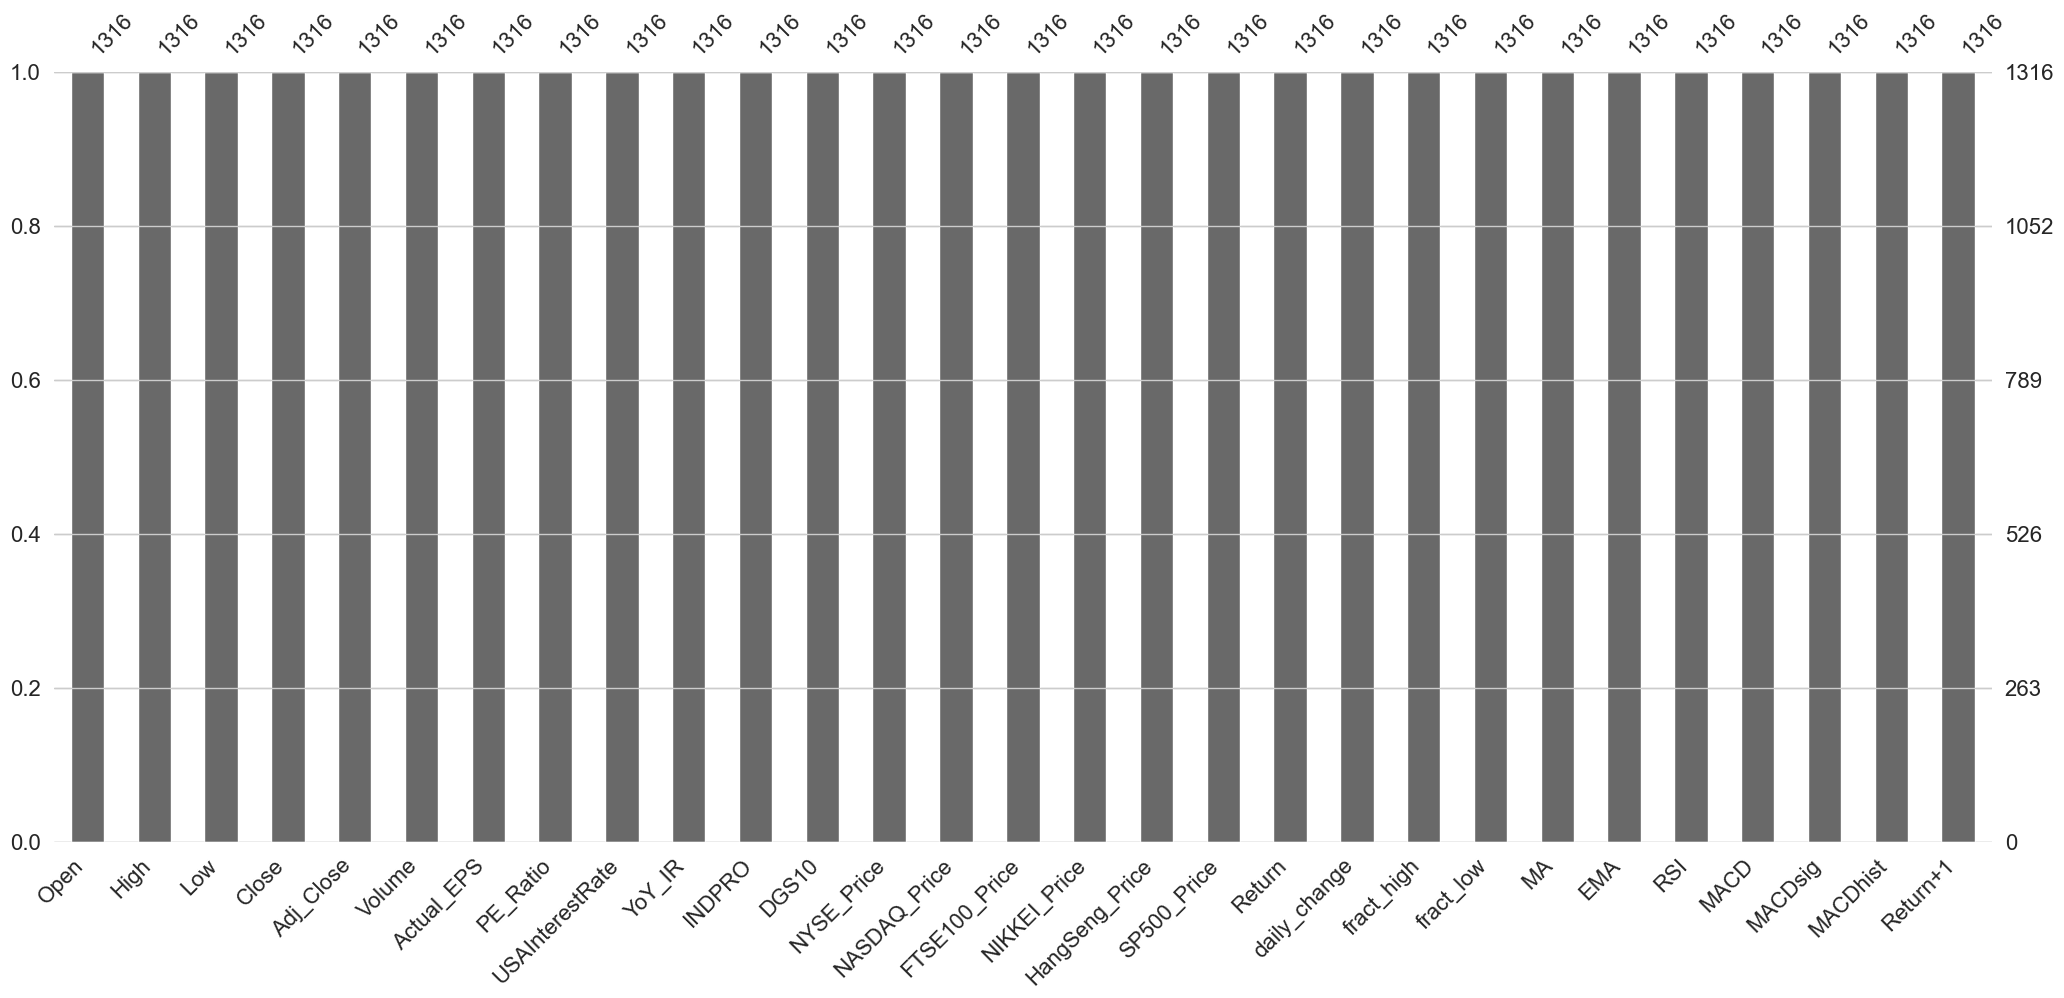

In [60]:
msno.bar(df)

#### Segmentación de variables de acuerdo a su naturaleza

* internos: 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'
* Técnicos: 'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist'
* Fundamental: 'Actual_EPS', 'PE_Ratio'
* Economicos: 'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10'
* Benchmark: 'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price'

## Parte 1: Entrenamos con todas las variables

##### Definimos las features a utilizar

In [61]:
X = df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
        'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist',
        'Actual_EPS', 'PE_Ratio',
        'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10',
        'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price']]

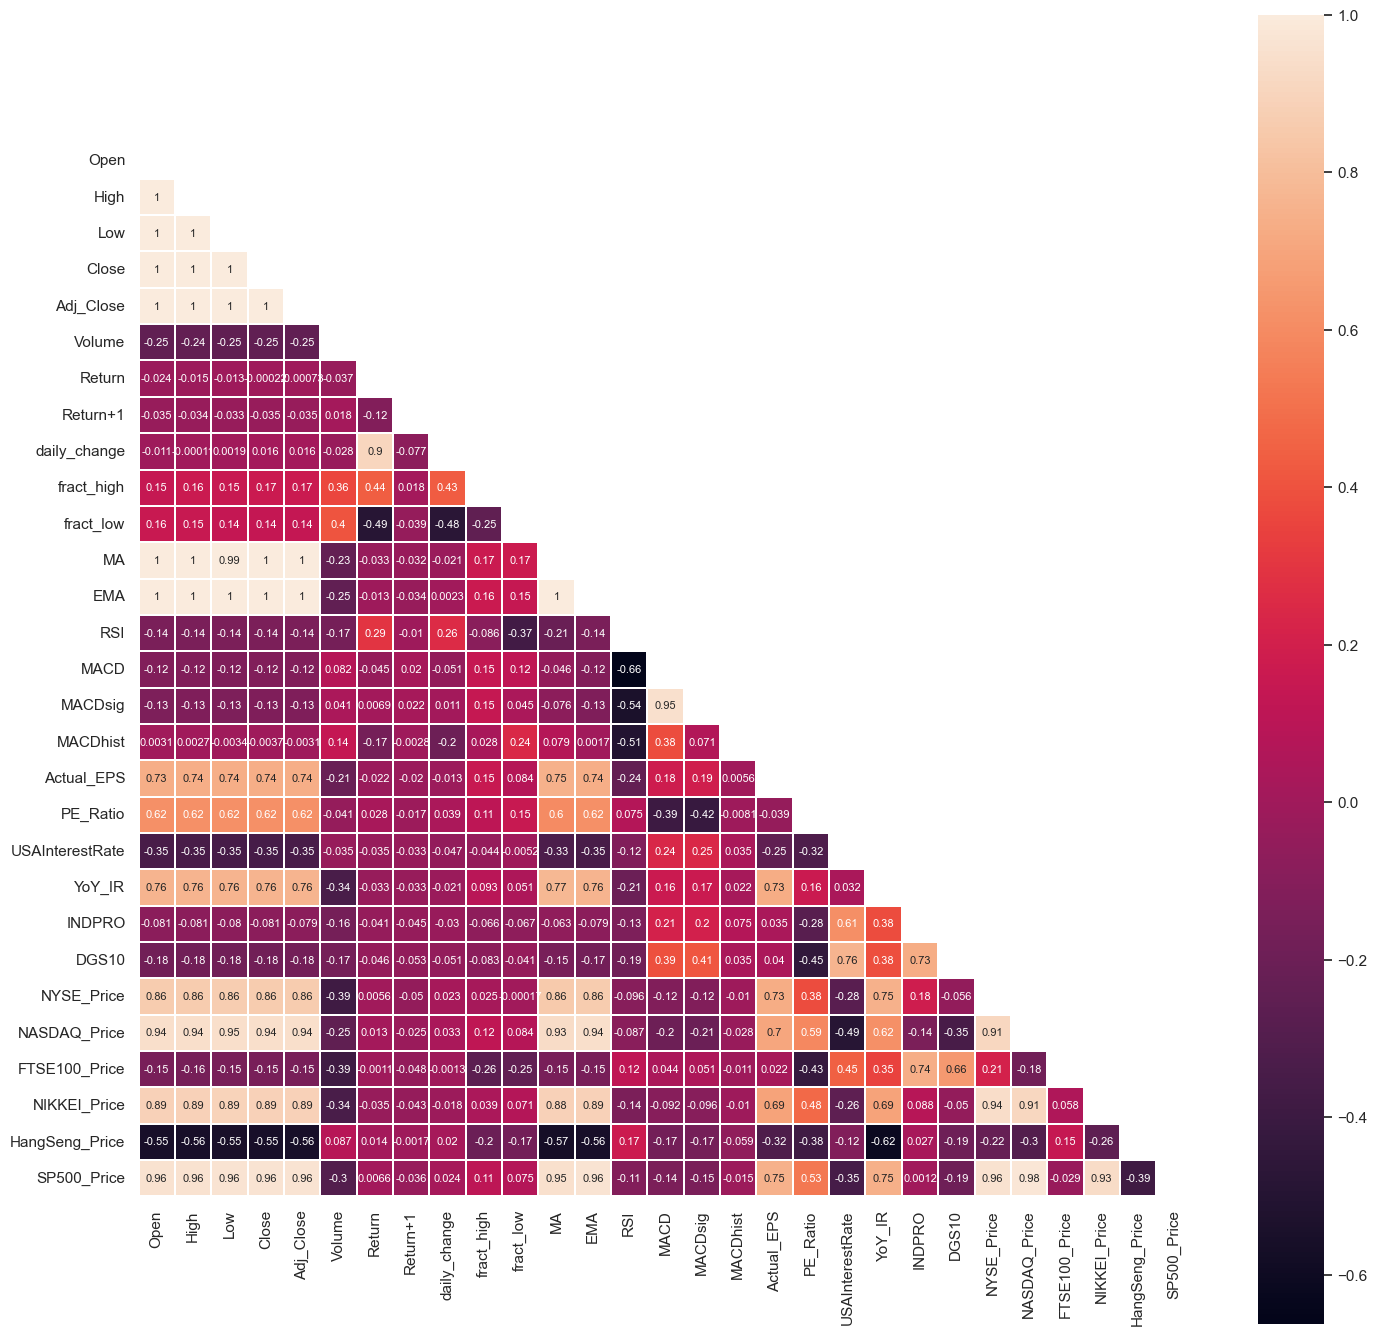

In [111]:
corrdf = df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
            'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist',
            'Actual_EPS', 'PE_Ratio',
            'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10',
            'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price']]

correlation_mat = corrdf.corr()

matrix = np.triu(correlation_mat)

plt.figure(figsize=(17, 17))
sns.heatmap(correlation_mat, vmin=correlation_mat.values.min(), vmax=1, square=True, 
            linewidths=0.1, annot=True, annot_kws={"size":8}, mask=matrix)
plt.show()

### Preprocessing

In [62]:
from sklearn.preprocessing import StandardScaler

ss =  StandardScaler().fit(X)
X_Scaled = ss.transform(X)

### PCA

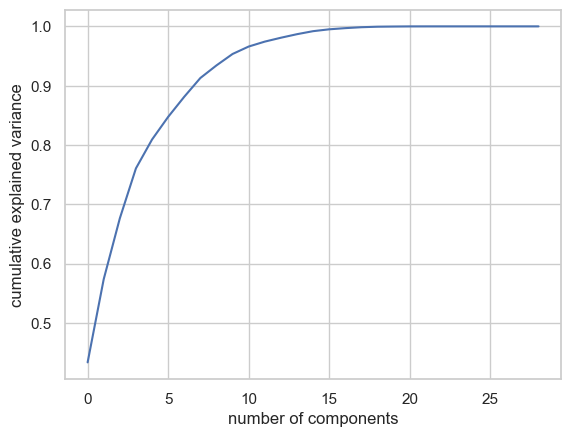

In [63]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_Scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Utilizando sobre 10 componentes ya tenemos +90% de varianza.

In [64]:
pca = PCA(n_components = 10)
pca.fit(X_Scaled)
X_pca = pca.transform(X_Scaled)

Validamos el número de componentes a utilizar

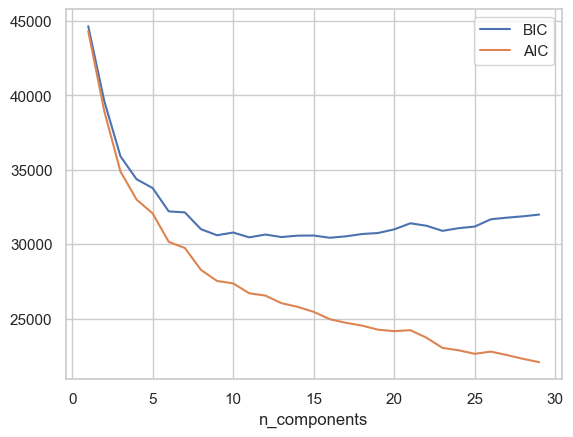

In [65]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [66]:
gmm = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 2023).fit(X_pca)
labels = gmm.predict(X_pca)

<AxesSubplot:xlabel='Fecha', ylabel='Adj_Close'>

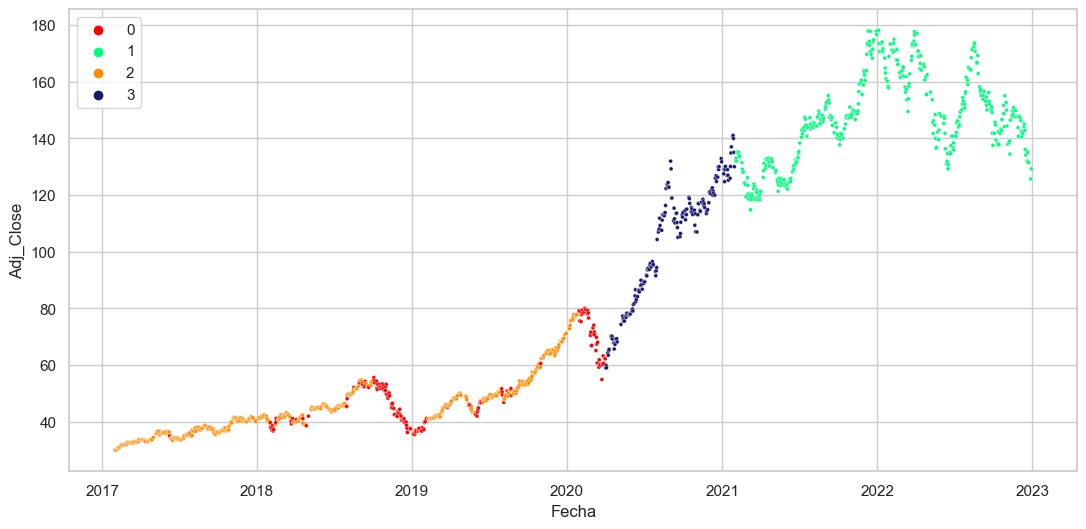

In [108]:
sns.set(style='whitegrid')
 
plt.figure(figsize=(13, 6), dpi = 100)
sns.scatterplot(x = df.index,
                    y = df.iloc[:, 4],
                    hue = labels,
                    palette = {0: 'red', 1: 'springgreen', 2: 'darkorange', 3: 'midnightblue'},
                    s = 8)

Se aprecia la segmentación en la data, sin embargo, no es muy especifico con las subidas y bajadas, si con tendencias de largo plazo.

## Parte 2: Se seleccionan solo algunas variables

In [113]:
# X2 = df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'PE_Ratio', 'daily_change', 'fract_high', 'fract_low',
#         'MA', 'EMA', 'RSI', 'MACD']]

X2 = df[['Return']].values.reshape(-1,1)

### Preprocessing

In [114]:
from sklearn.preprocessing import StandardScaler

ss =  StandardScaler().fit(X2)
X2_Scaled = ss.transform(X2)

### PCA

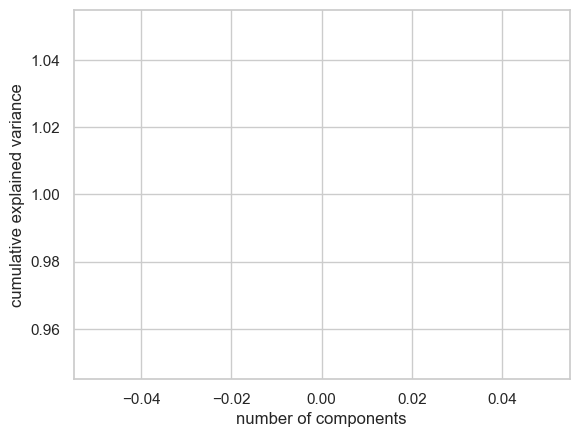

In [115]:
from sklearn.decomposition import PCA

pca2 = PCA().fit(X2_Scaled)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

A diferencia de utilizar todas las variables, ya con 3 componentes se explica más del 90% de la varianza. Se decide ocupar 6 componentes del PCA.

In [116]:
pca2 = PCA(n_components = 1)
pca2.fit(X2_Scaled)
X2_pca = pca2.transform(X2_Scaled)

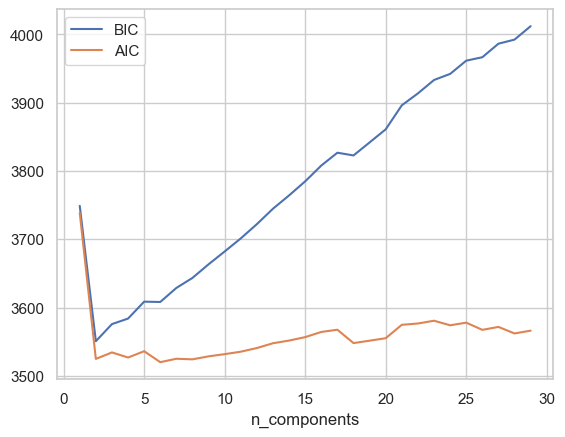

In [117]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X2_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X2_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X2_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Se deciden ocupar 4 componentes de estados en la GMM

In [118]:
gmm2 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 2023).fit(X2_pca)
labels2 = gmm2.predict(X2_pca)

''

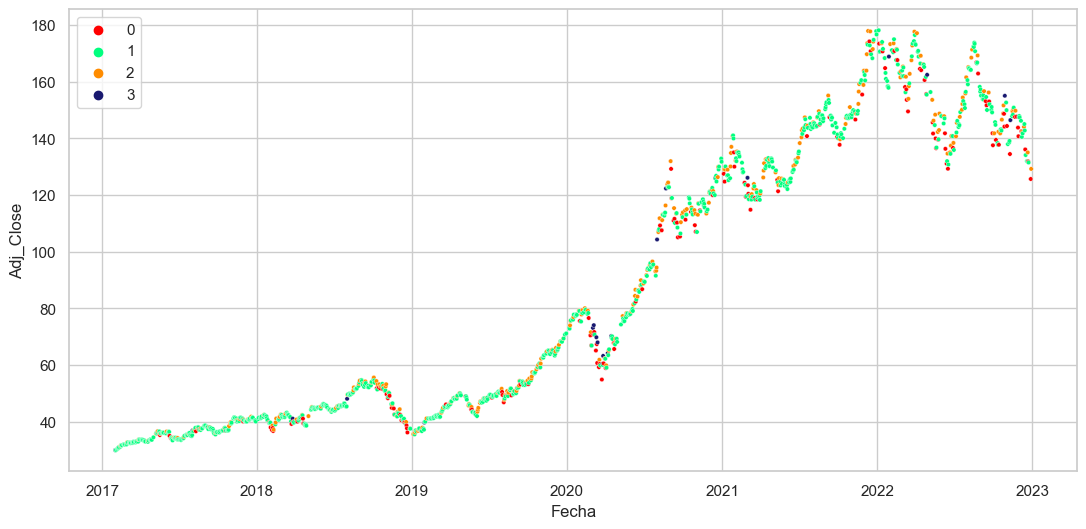

In [119]:
sns.set(style='whitegrid')


plt.figure(figsize=(13, 6), dpi = 100)
sns.scatterplot(x = df.index,
                    y = df.iloc[:, 4],
                    hue = labels2,
                    palette = {0: 'red', 1: 'springgreen', 2: 'darkorange', 3: 'midnightblue'},
                    s = 10)
;

Se obserba que el modelo es capaz de categorizar bien las alzas y bajas de los precios

In [126]:
dm = df
dm['labels'] = labels2
dm.groupby(['labels'])['Return+1'].agg(["mean", "median", "var"])

,mean,median,var
labels,,,
0,0.002267,0.000901,0.000844
1,0.001708,0.001049,0.000286
2,-0.000363,-0.000047,0.000352
3,-0.012388,-0.009307,0.001063


In [124]:
dm[['Adj_Close', 'Return', 'labels']]

,Adj_Close,Return,labels
Fecha,,,
2017-02-01,30.035210,0.060980,3
2017-02-02,29.983898,-0.001708,1
2017-02-03,30.112198,0.004279,1
2017-02-06,30.394468,0.009374,1
2017-02-07,30.683744,0.009517,1
...,...,...,...
2022-12-21,135.056702,0.023810,2
2022-12-22,131.846039,-0.023773,0
2022-12-23,131.477127,-0.002798,1


In [125]:
dm.to_excel('/Users/louisboza/Documents/Estudios/Diplomado/Proyecto/base_2.xlsx')